## <font color="DarkMagenta">This notebook will use A/B Testing as a vehicle for illustrating how several statistical methods can be applied to the problem of testing means and comparing samples. There are 6 Parts, some drawn from existing demonstrations on the web. In all cases, use of these materials is attributed.</font> 

---

## <font color='blue'>Part I: Some Examples of Successful A/B Tests are available at the Link Below:</font>

<center>https://www.designforfounders.com/ab-testing-examples/</center>

---

## <font color='blue'>Part II: A/B Testing With Python - Walkthrough Udacity's Course Final Project</font>

__[Udacity](https://www.udacity.com/)__ has published a great free course on A/B testing __[available here](https://www.udacity.com/course/ab-testing--ud257-certified)__. The notebook below was published by Tammy Rotem and is available at __[Tammy Rotem's Udacity A/B Project](https://www.kaggle.com/tammyrotem/ab-tests-with-python)__. NOTE: A few corrections to the referenced text were made.

 *By Tammy Rotem*
1. [About Udacity's A/B Testing Course](#about) <br>
2. [Experiment Overview](#overview)<br>
2.1 [Current Conditions Before Change](#current)<br>
2.2 [Description of Experimented Change](#description)<br>
2.3 [Experiment Hypothesis](#hypothesis)<br>
2.4 [Experiment Details](#details)<br>
3. [Metric Choice](#metricchoice)<br>
3.1 [Invariant Metrics - Consistency Checks](#Invariant)<br>
3.2 [Evaluation Metrics - Performance Indicators](#evaluation)<br>
4. [Estimating the baseline values of metrics](#baseline)<br>
4.1 [Collecting estimators data](#collect)<br>
4.2 [Estimating Stadard Deviation](#sd)<br>
4.2.1 [Estimating Analytically](#estimate)<br>
5. [Experiment Sizing](#sizing)<br>
5.1 [Get Z-score critical value and Standard Deviations](#z)<br>

5.2 [Calculate Sample Size per Metric](#calc) <br>
6. [Analyzing Collected Data](#analysis)<br>
6.1 [Loading collected data](#collect_results)<br>
6.2 [Consistency Checks](#consistency)<br>
6.2.1 [Consistency Checks for difference between Counts](#check_counts)<br>
6.2.2 [Consistency Checks for difference between probabilities](#check_probs)<br>
6.3 [Measuring effect size](#effect)<br>
6.4 [Double check with Sign Tests](#sign_tests)<br>
6.4.1 [Data Preparation](#prep)<br>
6.4.2 [Building a Sign Test](#sign)<br>
7. [Conclusions & Recommendations](#conclusions)<br>

In [1]:
import math
import numpy as np
import pandas.tseries as tseries
import pandas as pd
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import norm# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

## 1 Udacity's A/B Testing Course <a class="anchor" id="about"></a>
[Udacity](https://www.udacity.com/) published a great free course for [A/B Testing](https://en.wikipedia.org/wiki/A/B_testing), also known as split tests, which are online experiments used to test potential improvements to a website or mobile app.
This Python notebook is a walkthrough solution of the final project.

Udacity's [A/B Free Testing Course](https://www.udacity.com/course/ab-testing--ud257) is presented by Google and focuses on design and analysis of A/B tests. The course covers how to choose and characterize metrics to evaluate your experiments, how to design an experiment with enough statistical power and how to analyze the results and draw valid conclusions.

## 2 Experiment Overview <a class="anchor" id="overview"></a>

**Experiment Name:** "Free Trial" Screener. <br>
It is conducted by Udacity, a website dedicated to teaching online - with the overall business goal of maximizing course completion by students.
### 2.1 Current Conditions Before Change <a class="anchor" id="current"></a>

-  At the time of this experiment, Udacity courses currently have two options on the course overview page: "start free trial", and "access course materials". <br>
-  If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first.
-  If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.


### 2.2 Description of Experimented Change <a class="anchor" id="description"></a>

-  In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course.
-  If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free.
-  At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead. [This screenshot](https://drive.google.com/file/d/0ByAfiG8HpNUMakVrS0s4cGN2TjQ/view) shows what the experiment looks like.

### 2.3 Experiment Hypothesis <a class="anchor" id="hypothesis"></a>

The new screen is hypothesized to (1) improve retention of trial subscribers who drop out because of lack of time, while not reducing the numbers of students who continue past the free trial period.

### 2.4 Counting Cookies <a class="anchor" id="details"></a>
The unit of diversion (see discussion below for the distinction between units of diversion vs. units of analysis) is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page. __[Click here to find out more about cookies and internet tracking](https://robertheaton.com/2017/11/20/how-does-online-tracking-actually-work/)__

## 3 Choosing Metrics<a class="anchor" id="metric"></a>

We need two types of metrics for a successful experiment (or at least, a safe one); Invariant and Evaluation metrics.  

Invariant metrics are used for "Consistency checks", that is, to make sure our experiment (the way we presented a change to a part of the population, as well as the way we collected the data) is not inherently wrong. Basically, this means we pick metrics which are (presumably) unchanged by our experiment, which can then be compared between the control and experiment groups as consistency checks.<br>  
  
Evaluation metrics on the other hand, are measures that detect differences between control and experimental groups that, with proper experimental design, can be attributed to the "new treatment" of the experimental group. For each metric we state a $MinChng$ - the minimum change needed to replace control with experimental, e.g. requiring an increase in retentions of at least 2% (if statistically significant).
  
### 3.1 Invariant Metrics - Consistency Checks <a class="anchor" id="invariant"></a>

| Metric Name  | Metric Formula  | MinChng  | Notation |
|:-|:-|:-:|:-:|
| Number of Cookies in Course Overview Page  | # unique daily cookies on page | 3000 cookies  | $C_k$ |
| Number of Clicks on Free Trial Button  | # unique daily cookies who clicked  | 240 clicks | $C_l$ |
| Free Trial button Click-Through-Probability (CTP)  | $\frac{C_l}{C_k}$ | 0.01  | $CTP$ |   
  
### 3.2 Evaluation Metrics - Performance Indicators <a class="anchor" id="evaluation"></a>
| Metric Name  | Metric Formula  | MinChng  | Notation |
|:-:|:-:|:-:|:-:|
| Gross Conversion   |  $\frac{enrolled}{C_l}$  | 0.01  | $Conversion_{Gross}$ |
| Retention   | $\frac{paid}{enrolled}$  | 0.01  | $Retention$ |
| Net Conversion  |  $\frac{paid}{C_l}$  | 0.0075 | $Conversion_{Net}$ |

## 4 Estimating the baseline values of metrics <a class="anchor" id="baseline"></a>
Before we start our experiment we should know how these metrics behaved before the change - their "baseline" values.
### 4.1 Collecting estimators data <a class="anchor" id="collect"></a>
Udacity gives the following rough estimates for these metrics (presumably collected from aggregates on daily traffic) <br>

| Item | Description  | Estimator  |
|:-:|:-:|:-:|
| Number of cookies | Daily unique cookies to view course overview page  | 40,000  |
| Number of clicks | Daily unique cookies to click Free Trial button  | 3,200 |
| Number of enrollments | Free Trial enrollments per day  | 660  |
| CTP | CTP on Free Trial button  | 0.08  |
| Gross Conversion | Probability of enrolling, given a click  | 0.20625  |
| Retention | Probability of payment, given enrollment  | 0.53  |
| Net Conversion | Probability of payment, given click  | 0.109313 |

In [2]:
#Let's place this estimators into a dictionary for ease of use later
baseline = {"Cookies":40000,"Clicks":3200,"Enrollments":660,"CTP":0.08,"GConversion":0.20625,
           "Retention":0.53,"NConversion":0.109313}

#### 4.2.1 Estimating Standard Deviation <a class="anchor" id="estimate"></a>
In order to estimate variance we assume our count data (formally, the "count random variable") is binomially distributed with unknown probability $p$, for which the metric is the estimate of $p$, $\hat{p}$. The sample standard deviation $s$ is then calculated using the formula<br>

<center><font size="4">$s =\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$</font></center><br>

This setup is only valid when the **unit of diversion** of the experiment is equal to the **unit of analysis** (the denominator of the metric formula). In the cases when this is not valid, the actual variance might be different and it is recommended to estimate it empirically.

Here is what Professor Dimiter Toshkov says about **unit of diversion** (he calls it **unit of observation**, a better term) and **unit of analysis**:

"In my understanding, the unit of analysis (a case) is at the level at which you pitch the conclusions. The unit of observation is at the level at which you collect the data. So, the unit of observation and the unit of analysis can be the same but they need not be. In the context of quantitative research, units of observation could be students and units of analysis classes, if classes are compared. Or students can be both the units of observation and analysis if students are compared. Or students can be the units of analyses and grades the unit of observations if several observations (grades) are available per student. So it all depends on the design. Simply put, the unit of observation is the row in the data table but the unit of analysis can be at a higher level of aggregation."
__[Toshkov, January 25, 2012](http://re-design.dimiter.eu/?p=253)__

We now calculate sample standard deviations for three metrics:
-  Gross Conversion
-  Retention
-  Net Conversion

* **Gross Conversion** - The baseline probability for Gross Conversion can be estimated by the ratio of the number of users enrolling in a free trial to the number of cookies clicking the free trial. In this case, the units of diversion (Cookies) are the units that are assigned to control and experimental groups and which are observed as enrolling in the free trial or not.

In [3]:
# Let's get the p and n we need for Gross Conversion (GC) and compute
# the Sample Standard Deviation(sd) rounded to 4 decimal digits.
GC={}
GC["minch"]=0.01
GC["p"]=baseline["GConversion"]
# p is given in this case - or we could calculate it from enrollments/clicks
GC["n"]=baseline["Clicks"]
GC["sd"]=round(math.sqrt((GC["p"]*(1-GC["p"]))/GC["n"]),4)
GC["sd"]

0.0072

* **Retention** - The baseline probability for retention is the number of paying users (enrolled after 14 free days) divided by the number of total enrolled users, that is, the estimated probability of payment, given enrollment. The sample size is the number of enrolled users. In this case, unit of diversion is not equal to unit of analysis (users who enrolled) so an analytical estimation is not enough --- if we had the data for these estimates, we would want to estimate this variance empirically as well.

In [4]:
# Let's get the p and n we need for Retention(R)
# and compute the Standard Deviation(sd) rounded to 4 decimal digits.
R={}
R["minch"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["Enrollments"]
R["sd"]=round(math.sqrt((R["p"]*(1-R["p"]))/R["n"]),4)
R["sd"]

0.0194

* **Net Conversion** - The baseline probability for the net conversion is the number of paying users divided by the number of cookies that clicked the free trial button. In other words, the probability of payment, given a click. The sample size is the number of cookies that clicked. In this case, the unit of analysis and diversion are equal so we expect a good enough estimation analytically.

In [5]:
# Let's get the p and n we need for Net Conversion (NC) and
# compute the Standard Deviation (sd) rounded to 4 decimal digits.
NC={}
NC["minch"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]
NC["sd"]=round(math.sqrt((NC["p"]*(1-NC["p"]))/NC["n"]),4)
NC["sd"]

0.0055

## 5 Experiment Sizing <a class="anchor" id="sizing"></a>

A good online reference to hypothesis testing is

<center>[Hypothesis Testing (with Alpha & Beta) for One and Two Samples](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Power/BS704_Power_print.html)</center>

Having estimated probabilities and standard deviations for our metrics, we can now calculate sample sizes needed to perform tests with prescribed levels of significance and power.

Given the specifications of our A/B experiment, we want to test the (simple) null hypothesis $H_0 : P_{exp} - P_{cont} = 0$ vs $H_1 : P_{exp} - P_{cont} = d$. In the Gross Conversion (GC) test, for example $d = 0.01$ and the estimate of $P_{cont}$ is $\text{GC[``GConversion'']} = 0.20625$. Thus with our experimental 'B' "treatment", we wish to achieve at least a $1\%$ improvement to $0.21625$. Moreover, with a Type I error of $\alpha = 0.05$ (probability of rejecting a true null hypothesis) and Type II error of $\beta = 0.2$ (probability of accepting the null hypothesis when the alternative hypothesis $H_1$ is true) we want to conduct an experiment with sufficient sample size to reject $5\%$ of true null hypotheses $H_0: P_{exp} - P_{cont} = 0$, and accept $20\%$ when the alternative hypothesis $H_1 : P_{exp} - P_{cont} = d$ is true.

It is crucial to understand that we need to conduct a one-sided test of hypothesis here. The reason is obvious: if the experimental treatement reduces $P_{cont}$, that is, reduces the Gross Conversions, it will obviously be unattractive. In that case, one would only succeed in improving retentions if the reduction in CTP's was offset by a (considerably) higher retention probability.

With a large sample approximation, our test statistic under $H_0 : P_{exp} - P_{cont} = 0$ assuming large sample sizes $N_{cont}$ and $N_{exp}$, is (via the CLT):

<center><font size="4">$z = \frac{\hat{P}_{exp} - \hat{P}_{cont}}{\sqrt{\hat{P}_{pool} \left(1 - \hat{P}_{pool} \right)\left( \frac{1}{N_{cont}} + \frac{1}{N_{exp}} \right)}}$</font></center>  
  
where using the notation $x_{cont}$ and $x_{exp}$ for the numbers who click on free trial,   
  
<center><font size="4">$\hat{P}_{pool}=\frac{x_{cont}+x_{exp}}{N_{cont}+N_{exp}}$. </font></center>

The expression for $z$ will have a approximate $N(0,1)$ large sample distribution. Note that the justification for pooling the probability estimate is the assumption of the null hypothesis itself --- that $P_{exp} = P_{cont}$.  
  
Since we are randomizing cookies to control and experimental groups with probability $0.5$, we may assume equal sample sizes $N = N_{cont} = N_{exp}$ and then simplify the $z$ formula to 

<center><font size="4">$z = \frac{\hat{P}_{exp} - \hat{P}_{cont}}{\sqrt{\hat{P}_{pool} \left(1 - \hat{P}_{pool} \right) \frac{2}{N}}}$</font></center>  

Now suppose that the alternative hypothesis $H_1 : P_{exp} - P_{cont} = d$ is true. How does this affect our test statistic $z$? Approximately, we will have 

<center><font size="4">$z = \frac{d}{\sqrt{\hat{P}_{pool} \left(1 - \hat{P}_{pool} \right) \frac{2}{N}}}$</font></center> 

but the result is approximate because the standard deviation in the alternative should be based on $p + d$ in order to be normally distributed. If we ignore that difference, which is small when $d$ is small, it can be shown that the sample number required to achieve an approximate one-sided test with level of significance $1 - \alpha$ and power $1 - \beta$ is  
  
<center> <font size="5"> $n = \frac{ \left( Z_{1-\alpha} \cdot s_1 + Z_{1-\beta} \cdot s_2 \right) ^2}{d^2}$</font>, with <br><br>
$s_1 = \sqrt{\, \hat{P}(1-\hat{P})+\hat{P}(1-\hat{P})}$<br><br>
$s_2 = \sqrt{\, \hat{P}(1-\hat{P})+(\hat{P}+d)(1-(\hat{P}+d))}$ </center><br>  

Several online calculators are available to automatically determine sample size, for example
[Evan's Awesome A/B Tools](http://www.evanmiller.org/ab-testing/sample-size.html).
<font color=red>Warning: I do not see an option for performing a one-tailed test, although you can fake the calculator aout (probably) by using $\alpha = 0.10$ instead of $\alpha = 0.05$.</font>

Now, let's break down what inputs we need and which calculations still need to be made. Regarding inputs, we have all the data we need:  
  
-  Type 1 error ($\alpha$) 
-  power ($1-\beta$)
-  detectable change ($d = MinChng$)
-  baseline conversion rate (our $\hat{P}$, determined from historical data)  
  
What we need to calculate:  
  
* Get Z score for $1-\alpha$ and for $1-\beta$.
* Get standard deviations $s_1$ & $s_2$.

### 5.1 Get z-score Critical Value and Standard Deviations <a class="anchor" id="side_methods"></a>
The Python package `scipy.stats.norm` has functions for all the statistical function we need. The `ppf` method gives us access to the [Percent Point Function (ppf)](https://en.wikipedia.org/wiki/Quantile_function) or Quantile Function. This function is the inverse of the [Cummulative Distribution Function (cdf)](https://en.wikipedia.org/wiki/Cumulative_distribution_function), an allows the conversion of quantiles to cumulative probabilities and vice versa.  

In [6]:
#Inputs: required alpha value (alpha should already fit the required test)
#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

# Inputs p-baseline conversion rate which is our estimated p and d-minimum detectable change
# Returns
def get_sds(p,d):
    sd1=math.sqrt(2*p*(1-p))
    sd2=math.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# Inputs:sd1-sd for the baseline,sd2-sd for the expected change,alpha,beta,d-MinChng,p-baseline estimate p
# Returns: the minimum sample size required per group according to metric denominator
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

### 5.2 Calculate Sample Size per Metric <a class="anchor" id="calc"></a>
The functions in the previous two cells make it easy to calculate sample sizes for metrics (1) Gross Conversion, (2) Retention, and (3) Net Conversion.

In [7]:
GC["d"]=0.01
R["d"]=0.01
NC["d"]=0.0075

### <font color='blue'>*** Gross Conversion</font>

In [8]:
# Let's get an integer value for simplicity
GC["SampSize"]=round(get_sampSize(get_sds(GC["p"],GC["d"]),0.05,0.2,GC["d"]))
GC["SampSize"]

20364.0

This means we need at least 20,364 cookies who click the Free Trial button - per group! Finally, the total quantity of cookies (which are then assigned to either A or B) for the Gross Conversion metric is:

In [9]:
GC["SampSize"]=round(GC["SampSize"]/baseline["CTP"]*2)
GC["SampSize"]

509100.0

### <font color='blue'>*** Retention</font>

In [10]:
# Getting a nice integer value
R["SampSize"]=round(get_sampSize(get_sds(R["p"],R["d"]),0.05,0.2,R["d"]))
R["SampSize"]

30787.0

This means that we need 30,787 users who enrolled per group! We have to first convert this to cookies who clicked, and then to cookies who viewed the page, then finally to multiply by two for both groups.

In [11]:
R["SampSize"]=R["SampSize"]/baseline["CTP"]/baseline["GConversion"]*2
R["SampSize"]

3731757.575757576

Thus testing retentions would require over 3.7 million total page views, which at 40,000 views per day would require the test to extend for more than 90 days. But since we are willing to allocate no more than a month to testing, we do not test retentions due to insufficient sample size.
### <font color='blue'>*** Net Conversion</font>

In [12]:
# Getting a nice integer value
NC["SampSize"]=round(get_sampSize(get_sds(NC["p"],NC["d"]),0.05,0.2,NC["d"]))
NC["SampSize"]

21618.0

In [13]:
NC["SampSize"]=NC["SampSize"]/baseline["CTP"]*2
NC["SampSize"]

540450.0

total page views to achieve the $21,618$, given a CTP = $0.08$. Assuming we take 80% of each day's pageviews, the data collection period for this experiment (the period ending in the sample size is achieved) will be about 17 days. Note that running the experiment for a longer period will only improve its precision by reducing the effective level of significance and improving the power of the test.

## 6 Analyzing Collected Data <a class="anchor" id="analysis"></a>
Finally, the moment we've all been waiting for, after so much preparation we finally get to see what this experiment will prove!
The data is presented as two spreadsheets. I will load each spreadshot into a pandas dataframe.

### 6.1 Loading collected data <a class="anchor" id="collect_results"></a>

In [15]:
# we use pandas to load datasets
control=pd.read_csv("control_data.csv")
experiment=pd.read_csv("experiment_data.csv")
control.head(20)

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


### 6.2 Consistency Checks <a class="anchor" id="consistency"></a>
First thing we have to do before even beginning to analyze this experiment's results is consistency checks. These checks help verify that the experiment was conducted as expected and that other factors did not influence the data which we collected. This also makes sure that data collection was correct.

We have 3 Invariant metrics:: 
* Number of Cookies in Course Overview Page
* Number of Clicks on Free Trial Button
* Free Trial button Click-Through-Probability

Two of these metrics are simple counts like number of cookies or number of clicks and the third is a probability (CTP). We will use two different ways of checking whether these obsereved values are like we expect (if in fact the experiment was not damaged).

#### 6.2.1 Consistency Checks for differences between counts <a class="anchor" id="check_counts"></a>
* **Number of cookies who viewed the course overview page** - Starting from this simple invariant metric, we want to count the total number of cookie pageviews we diverted to each group and see if there is a significant difference in the number of cookies. A significant difference will imply a biased experiment that we should not rely on it's results.

In [16]:
pageviews_cont=control['Pageviews'].sum()
pageviews_exp=experiment['Pageviews'].sum()
pageviews_total=pageviews_cont+pageviews_exp
print ("number of pageviews in control:", pageviews_cont)
print ("number of Pageviewsin experiment:" ,pageviews_exp)

number of pageviews in control: 345543
number of Pageviewsin experiment: 344660


Since the number of pageviews was randomly assigned with $p = 0.5$. Therefore the sample number in the control group is a binomial random variable. Since the expected numbers in each group are $(345543 + 344660)/2 = 345101.5$, we use the test statistic 

<center>$z = \frac{345543 - 345101.5}{\sqrt{690203*(1/2)*(1/2)}} = 1.062851.$</center>

This result is not extreme, so we conclude that the sampling procedure was not aberrant.

In [17]:
p=0.5
alpha=0.05
p_hat=round(pageviews_cont/(pageviews_total),4)
sd=math.sqrt(p*(1-p)/(pageviews_total))
ME=round(get_z_score(1-alpha)*sd,4)
print ("The confidence interval is from 0 to",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is from 0 to 0.501 ; Is 0.5006 inside this range?


Our observed $\hat{p}$ is inside this range which means the difference in number of samples between groups is expected. So far so good, since this invariant metric consistency test passes!
* **Number of cookies who clicked the Free Trial Button**
We are going to address this count with the same strategy as before.

In [18]:
clicks_cont=control['Clicks'].sum()
clicks_exp=experiment['Clicks'].sum()
clicks_total=clicks_cont+clicks_exp

p_hat=round(clicks_cont/clicks_total,4)
sd=math.sqrt(p*(1-p)/clicks_total)
ME=round(get_z_score(1-alpha)*sd,4)
print ("The confidence interval is between 0 and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0 and 0.5035 ; Is 0.5005 inside this range?


We have another pass! Great, so far it still seems all is well with our experiment results. Now, for the final metric which is a probability.

#### 6.2.2 Consistency Checks for differences between probabilities <a class="anchor" id="check_prob"></a>
* ** Click-through-probability (CTP) of the Free Trial Button**
In this case, we want to make sure the proportion of clicks given a pageview (our observed CTP) is about the same in both groups (since this was not expected to change in the experiment). In order to check this out we will calculate the CTP in each group and calculate a confidence interval for the expected difference between them. 

In other words, we expect to see no difference ($CTP_{exp}-CTP_{cont}=0$), with an acceptable margin of error. The  pooled standard error to use in the z-test is:

<center><font size="4">$s_{pool}=\sqrt{\hat{P}_{pool}(1-\hat{P}_{pool}) \left( \frac{1}{N_{cont}}+\frac{1}{N_{exp}} \right) }$</font></center>
with <br> <center><font size="5"> $\hat{P}_{pool}=\frac{x_{cont}+x_{exp}}{N_{cont}+N_{exp}}$ </font></center>

In [19]:
ctp_cont=clicks_cont/pageviews_cont
ctp_exp=clicks_exp/pageviews_exp
d_hat=round(ctp_exp-ctp_cont,4)
p_pooled=clicks_total/pageviews_total
sd_pooled=math.sqrt(p_pooled*(1-p_pooled)*(1/pageviews_cont+1/pageviews_exp))
ME=round(get_z_score(1-alpha)*sd_pooled,4)
print ("The confidence interval is between 0 and",0+ME,"; Is",d_hat,"within this range?")

The confidence interval is between 0 and 0.0011 ; Is 0.0001 within this range?


Wonderful. It seems this test has passed with flying colors as well.

### 6.3 Examining effect size <a class="anchor" id="effect"></a>
The next step is looking at the changes between the control and experiment groups with regard to our evaluation metrics to make sure the difference is there, that it is statistically significant and most importantly practically significant (the difference is "big" enough to make the experimented change beneficial to the company).

Now, all that is left is to measure for each evaluation metric, the difference between the values from both groups. Then, we compute the confidence interval for that difference and test whether or not this confidence interval is both statistically and practically significant.

* **Gross Conversion**
A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)

> **Important:** The given spreadsheet lists pageviews and clicks for 39 days, while it only lists enrollments and payments for 23 days. So, when working with enrollments and payments we should notice using only the corresponding pageviews and clicks, and not all of them.

In [20]:
# Count the total clicks from complete records only
clicks_cont=control["Clicks"].loc[control["Enrollments"].notnull()].sum()
clicks_exp=experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()

In [21]:
#Gross Conversion - number of enrollments divided by number of clicks
enrollments_cont=control["Enrollments"].sum()
enrollments_exp=experiment["Enrollments"].sum()

GC_cont=enrollments_cont/clicks_cont
GC_exp=enrollments_exp/clicks_exp
GC_pooled=(enrollments_cont+enrollments_exp)/(clicks_cont+clicks_exp)
GC_sd_pooled=math.sqrt(GC_pooled*(1-GC_pooled)*(1/clicks_cont+1/clicks_exp))
GC_ME=round(get_z_score(1-alpha)*GC_sd_pooled,4)
GC_diff=round(GC_exp-GC_cont,4)
print("The change due to the experiment is",GC_diff*100,"%")
print("The Critical Point for a One-Sided Test is: ",GC_ME*100,"%]")

The change due to the experiment is -2.06 %
The Critical Point for a One-Sided Test is:  0.72 %]


Here is how to interpret this culminating test of Gross Conversions. (1) We determined the minimum sample size that would yield a 95% test of the null hypothesis and that also had a 20% of failing to detect a change in the alternative wof d=+1%. According to our sample size calculations, we needed a minimum of $509,100$ cookies in pageviews in order to achieve $509,100*0.08/2 = 20,364$ CTA's in each of the control and experimental groups. As noted earlier, if our sample numbers exceed $20,364$ the effective precision of the experiment can only be improved. (2) Our one sided test of the null hypothesis (GC_exp - GC_cont = 0), given a pooled standard error of $GC_exp - GC_cont$ of GC_ME = 0.72% is: Accept $H_0$ if $z\_score \le 0.72\%$, and Reject $H_0$ if $z\_score > 0.72\%$. (3) Since $-2.06\% < 0.72\%$ the null hypothesis is accepted, so we conclude that there is a low probability the experiment improves the Click-through-probability. But $-2.06\% < 1.0\%$, the minimum practical improvement that would be acceptable. Therefore we find no evidence fin favor of switching to the experimental method, at least on the Gross Conversion metric. Apparently, the precommitment (5 hours per week) dissuaded about $2\%$ of those who would have otherwise enrolled, an exceedingly bad result.

* **Net Conversion** 
The hypothesis is the same as before just with net conversion instead of gross. Given the results for Gross Conversions, we should expect the fraction of payers in the experimental group to decrease as well.

In [22]:
#Net Conversion - number of payments divided by number of clicks
payments_cont=control["Payments"].sum()
payments_exp=experiment["Payments"].sum()

NC_cont=payments_cont/clicks_cont
NC_exp=payments_exp/clicks_exp
NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
NC_sd_pooled=math.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
NC_ME=round(get_z_score(1-alpha)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("The change due to the experiment is",NC_diff*100,"%")
print("The Critical Point for a One-sided test is: ",NC_ME*100,"%]")

The change due to the experiment is -0.49 %
The Critical Point for a One-sided test is:  0.5599999999999999 %]


In this case we got a change size of less than $0.0075\%$ so the empirical findinga are not practically significant. But they are also not statistically significant since $-0.49\% < 0.07\%$. Unfortunately, we could not test Retentions directly, but this result moots that problem since reducing the number of payees relative to click throughs is the opposite of what is desired.

## 6.4 Double check with Sign Tests <a class="anchor" id="sign_tests"></a>
We can use a sign test to test a trend in the changes we observed in daily data. We compute the metric's value per day and then count on how many days the metric was lower in the experimental group and this will be the number of successes. Once this is defined we can look at the proportion of days of success out of all the available days.  
  
Note that we would prefer to examine changes hourly, or at some other interval, because there are only 37 days in the sample and 23 usable ones, a rather small number for a sign test.

### 6.4.1 Data Preparation <a class="anchor" id="prep"></a>

In [23]:
#let's first create the dataset we need for this:
# start by merging the two datasets
full=control.join(other=experiment,how="inner",lsuffix="_cont",rsuffix="_exp")
#Let's look at what we got
full.count()

Date_cont           37
Pageviews_cont      37
Clicks_cont         37
Enrollments_cont    23
Payments_cont       23
Date_exp            37
Pageviews_exp       37
Clicks_exp          37
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [24]:
#now we only need the complete data records
full=full.loc[full["Enrollments_cont"].notnull()]
full.count()

Date_cont           23
Pageviews_cont      23
Clicks_cont         23
Enrollments_cont    23
Payments_cont       23
Date_exp            23
Pageviews_exp       23
Clicks_exp          23
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [25]:
# Perfect! Now, derive a new column for each metric, so we have it's daily values
# We need a 1 if the experiment value is greater than the control value=
x=full['Enrollments_cont']/full['Clicks_cont']
y=full['Enrollments_exp']/full['Clicks_exp']
full['GC'] = np.where(x<y,1,0)
# The same now for net conversion
z=full['Payments_cont']/full['Clicks_cont']
w=full['Payments_exp']/full['Clicks_exp']
full['NC'] = np.where(z<w,1,0)
full.head()

,Date_cont,Pageviews_cont,Clicks_cont,Enrollments_cont,Payments_cont,Date_exp,Pageviews_exp,Clicks_exp,Enrollments_exp,Payments_exp,GC,NC
0,"Sat, Oct 11",7723,687,134.0,70.0,"Sat, Oct 11",7716,686,105.0,34.0,0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,"Sun, Oct 12",9288,785,116.0,91.0,0,1
2,"Mon, Oct 13",10511,909,167.0,95.0,"Mon, Oct 13",10480,884,145.0,79.0,0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,"Tue, Oct 14",9867,827,138.0,92.0,0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,"Wed, Oct 15",9793,832,140.0,94.0,0,1


In [26]:
GC_x=full.GC[full["GC"]==1].count()
NC_x=full.NC[full["NC"]==1].count()
n=full.NC.count()
print("No. of cases for GC:",GC_x,'\n',
      "No. of cases for NC:",NC_x,'\n',
      "No. of total cases",n)

No. of cases for GC: 4 
 No. of cases for NC: 10 
 No. of total cases 23


### 6.4.2 Building a Sign Test <a class="anchor" id="sign"></a>
We can forget all about this part and just use an [online sign test calculator](https://www.graphpad.com/quickcalcs/binomial2/), but for me that is just no fun - so I will implement the calculations behind it. <br>
What we want to do after we count the amount of days in which the experiment group had a higher metric value than that of the control group, is to see if that number is likely to be seen again in a new experiment (significance). We assume the chance of a day like this is random (50% chance to happen) and then use the binomial distribution with $p=0.5$ and the number of experiments (days) to tell us the probability of this happening according to a random chance.<br>
So, according to the binomial distribution with $p=0.5$ and $n=$total number of days; we want to now the probability of $x$ days being a success (higher metric value in experiment). Because we are doing a two-tailed test we want to double this probability and once we have we can call it the $p-value$ and compare it to our $\alpha$. If the $p-value$ is greater than the $\alpha$ the result is not significant and vice-versa.<br>
<center><font size="4"> $p(successes )=\frac{n!}{x!(n-x)!}p^x(1-p)^{n-x}$ </font></center>
Recall that a $p-value$ is the probability of observing a test statistic as or more extreme than that observed. If we observed 2 days like that, the $p-value$ for the test is: $p-value = P(x <= 2)$. We only need to remember the following:<br>
<center>$P(x<=2)=P(0)+P(1)+P(2)$.</center><br>For more detailed information, visit [this excellent page](http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/BS704_Nonparametric5.html).


In [27]:
#first a function for calculating probability of x=number of successes
def get_prob(x,n):
    p=round(math.factorial(n)/(math.factorial(x)*math.factorial(n-x))*0.5**x*0.5**(n-x),4)
    return p
#next a function to compute the pvalue from probabilities of maximum x
def get_2side_pvalue(x,n):
    p=0
    for i in range(0,x+1):
        p=p+get_prob(i,n)
    return 2*p

Finally, to conduct the sign test itself: we will calculate the p-value for each metric, using the counts `GC_x`,`NC_x` and `n` and the function `get_2side_pvalue`.

In [28]:
print ("GC Change is significant if",get_2side_pvalue(GC_x,n),"is smaller than 0.05")
print ("NC Change is significant if",get_2side_pvalue(NC_x,n),"is smaller than 0.05")

GC Change is significant if 0.0026000000000000003 is smaller than 0.05
NC Change is significant if 0.6774 is smaller than 0.05


We get a different conclusion from our that for effect sizes: the change in Gross conversion was not significant but the sign test is significant. Neither test was significant for Net conversions.

## 7 Conclusions & Recommendations <a class="anchor" id="conclusions"></a>
At this point, once we have seen that the actual underlying goal we had was not reached (increase fraction of paying users by asking them in advance if they have the time to invest in the course), we can only recommend to not continue with change. It may have caused a change in Gross conversion, but it didn't for net conversion.

A wonderful summary of this experiment, analysis and results, by the amazing Andrew Bauman, can be found [here](https://github.com/baumanab/udacity_ABTesting#summary).

---

## <font color='blue'>Part III: A/B Testing with the Bootstrap</font>

We revisit a tutorial for bootstrap methodology (**First 30 Slides Only!**), then give a Python demonstration below.  
  
<center>[Bootstrap Tutorial (Stine)](http://www-stat.wharton.upenn.edu/~stine/research/spida_2005.pdf)</center>


In [29]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In general A/B tests attempt to improve the metric for B over the one for A. One measure of the improvement is **lift**, defined as $\frac{m_B}{m_A}$, where $m$ is the metric and $m_A > 0$ and $m_B > 0$.

In [30]:
# little A/B test
# score in test are 10% greater than ctrl (per record)
# ctrl has 5x the number of records as test

# 10% lift in test
lift = 1.1
test = np.random.binomial(100, p=0.2 * lift, size=10000) * 1.0
ctrl = np.random.binomial(100, p=0.2, size=50000) * 1.0

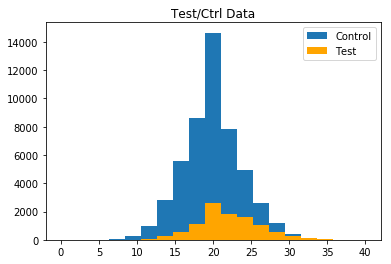

In [31]:
bins = np.linspace(0, 40, 20) # 20 bins of width 2 between 0 and 40.

plt.hist(ctrl, bins=bins, label='Control')
plt.hist(test, bins=bins, label='Test', color='orange')
plt.title('Test/Ctrl Data')
plt.legend()

Note the significant right skew in the Test histogram.

In [32]:
# Run an A/B test simulation ignoring the lengths of the series (average)
# Just what is the 'typical' value
# use percent change to compare test and control

print(bs_compare.percent_change(test.mean(), ctrl.mean()))

print(bs.bootstrap_ab(test, ctrl, bs_stats.mean, bs_compare.percent_change))

9.973416904045537
9.973416904045537    (9.507270232707254, 10.431125560176593)


According to the *bs_compare.percent_change* function, the test mean is about $10\%$ higher than the control mean. This figure will vary from run to run --- why? Furthermore, the confidence interval is approximately (9.5, 10.5) does not contain zero, indicating that the means are significantly different.  
  
The third argument of *bs.bootstrap_ab* is *stat_func* the test statistic we use for each bootstrap sample. The fourth argument is *compare_func*, the function we use to compare the *stat_func*'s for test and control.
  
Here are the arguments to the bootstrapped.bootstrap_ab function. How many replications were made in the invocation of this function in the previous cell?
  
bs.bootstrap_ab(<br> 
> test,<br> 
> ctrl,<br> 
> stat_func,<br>
> compare_func,<br> 
> test_denominator=None,<br> 
> ctrl_denominator=None,<br> 
> alpha=0.05,<br> 
> num_iterations=10000,<br> 
> iteration_batch_size=None,<br> 
> scale_test_by=1.0,<br> 
> is_pivotal=True,<br> 
> num_threads=1,<br> 
> return_distribution=False)<br> 

In [33]:
print(len(test))
print(len(ctrl))

10000
50000


In [34]:
# Run an A/B test simulation considering the lengths of the series (sum)
# consider the full 'volume' of values that are passed in

print(bs_compare.percent_change(test.sum(), ctrl.sum()))

print(bs.bootstrap_ab(
    test, 
    ctrl, 
    stat_func=bs_stats.sum,
    compare_func=bs_compare.percent_change
))

-78.00531661919089
-78.00531661919089    (-78.09454502085616, -77.91448316682596)


**Advice**: For most situations we reccomend that we use 'sum' aggregate function as this will take the size of the population into account. This can be useful if you think your test will increase the total number of individuals in the population and not only the typical value per individual.

**Exception to the above advice**

There are situations where you might need to make some adjustments, for example if your holdouts are sized differently.

You give 100 dollars to person_A and you give 1000 dollars to person_B to bring people to your store. Say you don't know how many people person_A or person_B went after but they did each get paying customers to attend. However you do need to correct at the end for the fact that you gave person_B 10x more money than person_A

In [35]:
# Gave $100, got 1k events on the store, $20 per event 
person_A_results = np.random.binomial(100, p=0.2, size=1000) * 1.0

# Gave $1000, got 5k events on the store, $30 per event
person_B_results = np.random.binomial(100, p=0.3, size=5000) * 1.0

In [36]:
# The test earned much less in terms of total dollars
print(bs.bootstrap_ab(
    person_A_results, 
    person_B_results, 
    stat_func=bs_stats.sum,
    compare_func=bs_compare.difference,
))

-129718.0    (-130404.0, -129030.0)


In [37]:
# The test gives ~$10 less per event
print(bs.bootstrap_ab(
    person_A_results, 
    person_B_results, 
    stat_func=bs_stats.mean,
    compare_func=bs_compare.difference,
))

-10.0916    (-10.370409999999998, -9.813790000000001)


In [38]:
# If we scale the text by $$ spent - person_A should be a better return on investment
#  - assuming person_A can achieve similar results with 10x more money
print(bs.bootstrap_ab(
    person_A_results, 
    person_B_results, 
    stat_func=bs_stats.sum,
    compare_func=bs_compare.difference,
    scale_test_by=10.,
))

48617.0    (46087.975000000006, 51136.0)


---

## <font color='blue'>Part IV: T-Tests for One and Two Samples</font>

## <font color='blue'>Create Data</font>

In [39]:
np.random.seed(6)

population_ages1 = stats.poisson.rvs(loc=18, mu=35, size=150000)
population_ages2 = stats.poisson.rvs(loc=18, mu=10, size=100000)
population_ages = np.concatenate((population_ages1, population_ages2))
# This 'concatenate' command joins the Poisson sample of 150,000 & 
#   the one of 100,000, and designates that as the "Population" of
#   250,000. Note that the Poisson is located at 18. Therefor the 
#   mean of the ages is 35*3/5 + 10*2/5 + 18 = 43. The mean shown below
# is very close to the theoretical because of the large sample size.

minnesota_ages1 = stats.poisson.rvs(loc=18, mu=30, size=30)
minnesota_ages2 = stats.poisson.rvs(loc=18, mu=10, size=20)
minnesota_ages = np.concatenate((minnesota_ages1, minnesota_ages2))
# This 'concatenate' command joins a simulated 'random sample' of 50 
#   values. The sample has the same 3:2 ratio of the Population, but
#   the 30 ages1 values have mean 30 rather than 35. In this 
#   sample, the theoretical mean is 30*3/5 + 10*2/5 + 18 = 40. 

print( population_ages.mean() )
print( minnesota_ages.mean() )
# Differences between population due to mu=35 in Pop vs mu=30 

43.000112
39.26


## <font color='blue'>One Sample t-test</font>

In [40]:
# This is for demonstration only - in practice we (allmost) never 
# know the entire population. The one sammple test is used most 
# commonly when there is a particular value that the mean should
# have under a null hypothesis.
stats.ttest_1samp(a= minnesota_ages,                # Sample data
                  popmean= population_ages.mean())  # Pop mean

Ttest_1sampResult(statistic=-2.5742714883655027, pvalue=0.013118685425061678)

In [41]:
stats.t.ppf(q=0.025,  # Quantile to check
            df=49)    # Degrees of freedom df = 30 + 20 - 1

-2.0095752344892093

In [42]:
sigma = minnesota_ages.std()/math.sqrt(50)    # Sample stdev/sqrt(sample size)

# This command produces a 95% confidence interval for the minnesota sample. 
# Note that it would work for any sample.
# It assumes the 'center' is the 'loc' parameter, and 'standard deviation'
# is the 'scale' parameter.
stats.t.interval(0.95,                        # Confidence level
                 df = 49,                     # Degrees of freedom
                 loc = minnesota_ages.mean(), # Sample mean
                 scale= sigma)                # Standard dev estimate

(36.369669080722176, 42.15033091927782)

In [43]:
# And this one, 99% confidence interval. 
stats.t.interval(alpha = 0.99,                # Confidence level
                 df = 49,                     # Degrees of freedom
                 loc = minnesota_ages.mean(), # Sample mean
                 scale= sigma)                # Standard dev estimate

(35.40547994092107, 43.11452005907893)

## <font color='blue'>Two Sample t-test</font>

In [44]:
# In simulations, the same random sequence can be generated by using 
# the same seed. If the seed below were changed, 
np.random.seed(12)

# Create a second sample.
wisconsin_ages1 = stats.poisson.rvs(loc=18, mu=33, size=30)
wisconsin_ages2 = stats.poisson.rvs(loc=18, mu=13, size=20)
wisconsin_ages = np.concatenate((wisconsin_ages1, wisconsin_ages2))

print( wisconsin_ages.mean() )

42.8


In [45]:
# The ttest_ind applies the ttest to 'independent' samples of minnesota_ages
# and wisconsin_ages.
stats.ttest_ind(a= minnesota_ages,
                b= wisconsin_ages,
                equal_var=False)    # Assume samples have equal variance?

Ttest_indResult(statistic=-1.7083870793286842, pvalue=0.09073104343957748)

## <font color='blue'>Paired t-test</font>

In [46]:
# Create a simulated paired dataset.
# Note that the 'after' variable adds a bit of normal 
# noise to before with an offset of -1.25.

np.random.seed(11)
before= stats.norm.rvs(scale=30, loc=250, size=100)
after = before + stats.norm.rvs(scale=5, loc=-1.25, size=100)
weight_df = pd.DataFrame({"weight_before":before,
                          "weight_after":after,
                          "weight_change":after-before})
weight_df.describe()      

,weight_before,weight_after,weight_change
count,100.000000,100.000000,100.000000
mean,250.345546,249.115171,-1.230375
std,28.132539,28.422183,4.783696
min,170.400443,165.913930,-11.495286
25%,230.421042,229.148236,-4.046211
50%,250.830805,251.134089,-1.413463
75%,270.637145,268.927258,1.738673
max,314.700233,316.720357,9.759282


In [47]:
# The command ttest_rel performs a paired t-test on variables 'before' 
# and 'after'. The test is valid on this small sample of 100 because 
# the 'before - after' values are normally distributed by construction.
stats.ttest_rel(a = before,
                b = after)

Ttest_relResult(statistic=2.5720175998568284, pvalue=0.011596444318439857)

## <font color='blue'>Part V: Maximum Likelihood</font>

### <font color='blue'>Simulate Data</font>

In [48]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

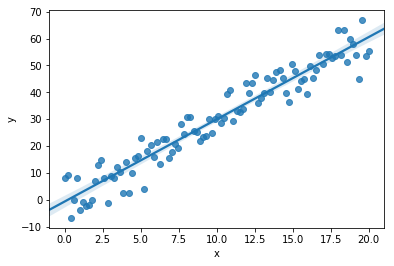

In [49]:
# plot
sns.regplot(df.x, df.y);

### <font color='blue'>Maximum Likelihood Estimates for a Normal Distribution</font>

In [50]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1228.
Date:                Sun, 04 Nov 2018   Prob (F-statistic):           3.11e-57
Time:                        22:39:35   Log-Likelihood:                -303.70
No. Observations:                 100   AIC:                             611.4
Df Residuals:                      98   BIC:                             616.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.6911      1.011     -0.683      0.496      -2.698       1.316
x              3.0610      0.087     35.038      0.000       2.888       3.234
==============================================================================
Omnibus:                        1.063   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                1.090
Skew:                          -0.141   Prob(JB):                        0.580
Kurtosis:                       2.573   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# define likelihood function
def MLERegression(params):
 intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
 yhat = intercept + beta*x # predictions
# next, we flip the Bayesian question
# compute PDF of observed values normally distributed around mean (yhat)
# with a standard deviation of sd
 negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
# return negative LL
 return(negLL)

In [52]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = optimize.minimize(MLERegression, guess, method = 'Nelder-Mead')

In [53]:
results

 final_simplex: (array([[-0.6910448 ,  3.06104578,  5.04345122],
       [-0.69111898,  3.06105256,  5.04344869],
       [-0.69106866,  3.06104844,  5.04343591],
       [-0.69106002,  3.06104451,  5.04345114]]), array([303.70299834, 303.70299834, 303.70299834, 303.70299834]))
           fun: 303.7029983388984
       message: 'Optimization terminated successfully.'
          nfev: 174
           nit: 96
        status: 0
       success: True
             x: array([-0.6910448 ,  3.06104578,  5.04345122])

## <font color='blue'>Part VI: Duke Bootstrap Tutorial</font>

Tutorial taken from the Duke website

https://people.duke.edu/~ccc14/sta-663/ResamplingAndMonteCarloSimulations.html

### <font color='blue'>Selecting random subsets using numpy</font>

In [ ]:
import glob

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [ ]:
np.set_printoptions(formatter={'float': lambda x: '%.3f' % x})
np.random.seed(123)

In [ ]:
# Sampling is done with replacement by default
np.random.choice(4, 12)

In [ ]:
x = np.random.randint(0, 10, (8, 12))
x

In [ ]:
# sampling individual elements
np.random.choice(x.ravel(), 12)

In [ ]:
# sampling rows
idx = np.random.choice(x.shape[0], 4)
x[idx, :]

In [ ]:
x

In [ ]:
np.random.shuffle(x)
x

In [ ]:
np.random.shuffle(x.T)
x

In [ ]:
np.random.permutation(x)

In [ ]:
# Use indices if you needed to shuffle collections of arrays in synchrony
x = np.arange(12).reshape(4,3)
y = x + 10
idx = np.random.permutation(x.shape[0])
print(x[idx, :])
print(y[idx, :])

### <font color='blue'>Illustration of the Bootstrap</font>

In [ ]:
# For example, what is the 95% confidence interval for
# the mean of this data set if you didn't know how it was generated?

x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step');

In [ ]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps))
mb = xb.mean(axis=0)
mb.sort()

np.percentile(mb, [2.5, 97.5])

In [ ]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

In [ ]:
# data sample for integration
n = 100
x = f(np.random.random(n))

In [ ]:
# bootstrap MC integration
reps = 1000
xb = np.random.choice(x, (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

In [ ]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

## <font color='blue'>Permutation Resampling</font>

In [ ]:
def stirling(n):
    """Stirling's approximation to the factorial."""
    return np.sqrt(2*np.pi*n)*(n/np.e)**n

n = np.arange(1, 51)
zip(n, stirling(n))

In [ ]:
x = np.concatenate([np.random.exponential(size=200),
                    np.random.normal(0, 1, size=100)])
y = np.concatenate([np.random.exponential(size=250),
                    np.random.normal(0, 1, size=50)])

In [ ]:
n1, n2 = map(len, (x, y))
reps = 10000

data = np.concatenate([x, y])
ps = np.array([np.random.permutation(n1+n2) for i in range(reps)])

In [ ]:
xp = data[ps[:, :n1]]
yp = data[ps[:, n1:]]
samples = np.percentile(xp, 7, axis=1) - np.percentile(yp, 7, axis=1)

In [ ]:
plt.hist(samples, 25, histtype='step')
test_stat = np.percentile(x, 7) - np.percentile(y, 7)
plt.axvline(test_stat)
plt.axvline(np.percentile(samples, 2.5), linestyle='--')
plt.axvline(np.percentile(samples, 97.5), linestyle='--')
print("p-value =", 2*np.sum(samples >= np.abs(test_stat))/reps)

In [ ]:
np.random.seed(52)

ngenes = 100
ncases = 500
nctrls = 500
nsamples = ncases + nctrls
x = np.random.normal(0, 1, (ngenes, nsamples))

In [ ]:
t, p0 = stats.ttest_ind(x[:, :ncases], x[:, ncases:], axis=1)
idx = p0 < 0.05
zip(np.nonzero(idx)[0], p0[idx])

In [ ]:
vmin = x.min()
vmax = x.max()

plt.subplot(121)
plt.imshow(x[:, :ncases], extent=[0, 1, 0, 2], interpolation='nearest',
           vmin=vmin, vmax=vmax, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title('Controls')
plt.subplot(122)
plt.imshow(x[:, ncases:], extent=[0, 1, 0, 2], interpolation='nearest',
           vmin=vmin, vmax=vmax, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title('Cases')
plt.colorbar();

In [ ]:
p1 = np.clip(ngenes * p0, 0, 1)
idx = p1 < 0.05
zip(np.nonzero(idx)[0], p1[idx])

In [ ]:
# Let's see if the smallest adjusted p-value is significant
k = 0
p0s = np.array(sorted(p0))
print("Gene\tUnadjusted p")
print(np.argsort(p0)[k], '\t', p0s[k])

In [ ]:
# Do many permutations
nperms = 10000

ps = np.zeros(nperms)
for i in range(nperms):
    sidx = np.random.permutation(nsamples)
    y = x[:, sidx]
    pvals = stats.ttest_ind(y[:, :ncases], y[:, ncases:], axis=1)[1]
    pvals.sort()
    ps[i] = pvals[k]

print("Gene\tUnadjusted p\t\tAdjusted p")
print(np.argsort(p0[k]), '\t', p0s[k], '\t', np.sum(ps < p0s[k])/nperms)

In [ ]:
# This is the maxT step-down method
# Assumes that the distribution of T-statistics is the same for all genes

nperms = 10000
k = ngenes

counts = np.zeros((nperms, k))
ranks = np.argsort(np.abs(t))[::-1]
for i in range(nperms):
    u = np.zeros(k)
    sidx = np.random.permutation(nsamples)
    y = x[:, sidx]
    tb, pb = stats.ttest_ind(y[:, :ncases], y[:, ncases:], axis=1)
    u[k-1] = np.abs(tb[ranks[k-1]])
    for j in range(k-2, -1, -1):
        u[j] = max(u[j+1], np.abs(tb[ranks[j]]))
    counts[i] = (u >= np.abs(t[ranks]))

p2 = np.sum(counts, axis=0)/nperms
for i in range(1, k):
    p2[i] = max(p2[i],p2[i-1])
idx = p2 < 0.05
zip(ranks, p2[idx])

In [ ]:
plt.plot(sorted(p0), label='No correction')
plt.plot(sorted(p1), label='Bonferroni')
plt.plot(sorted(p2), label='Westfall-Young')
plt.ylim([0,1])
plt.legend(loc='best');

In [ ]:
np.random.seed(52)

ngenes = 100
ncases = 500
nctrls = 500
nsamples = ncases + nctrls

x = np.repeat(np.random.normal(0, 1, (1, nsamples)), ngenes, axis=0)

In [ ]:
x[:5,:5]

In [ ]:
t, p0 = stats.ttest_ind(x[:, :ncases], x[:, ncases:], axis=1)
idx = p0 < 0.05
print('Minimum p-value', p0.min(), '# significant', idx.sum())

In [ ]:
p1 = np.clip(len(p0) * p0, 0, 1)
idx = p1 < 0.05
print('Minimum p-value', p1.min(), '# significant', idx.sum())

In [ ]:
nperms = 10000

counts = np.zeros((nperms, k))
ranks = np.argsort(np.abs(t))[::-1]
for i in range(nperms):
    u = np.zeros(k)
    sidx = np.random.permutation(nsamples)
    y = x[:, sidx]
    tb, pb = stats.ttest_ind(y[:, :ncases], y[:, ncases:], axis=1)
    u[k-1] = np.abs(tb[ranks[k-1]])
    for j in range(k-2, -1, -1):
        u[j] = max(u[j+1], np.abs(tb[ranks[j]]))
    counts[i] = (u >= np.abs(t[ranks]))

p2 = np.sum(counts, axis=0)/nperms
for i in range(1, k):
    p2[i] = max(p2[i],p2[i-1])
idx = p2 < 0.05

print('Minimum p-value', p2.min(), '# significant', idx.sum())

In [ ]:
plt.plot(sorted(p1), label='Bonferroni')
plt.plot(sorted(p2), label='Westfall-Young')
plt.ylim([-0.05,1.05])
plt.legend(loc='best');

## <font color='blue'>Monte Carlo Simulations</font>

### <font color='blue'>Power of a Test</font>

In [ ]:
# Run nresps simulations
# The power is simply the fraction of reps where
# the p-value is less than 0.05

nreps = 10000
d = 0.5

n = 50
power = 0
while power < 0.8:
    n1 = n2 = n
    x = np.random.normal(0, 1, (n1, nreps))
    y = np.random.normal(d, 1, (n2, nreps))
    t, p = stats.ttest_ind(x, y)
    power = (p < 0.05).sum()/nreps
    print(n, power)
    n += 1

### <font color='blue'>Estimate a CDF</font>

In [ ]:
# Make up some random data
x = np.concatenate([np.random.normal(0, 1, 10000),
                    np.random.normal(4, 1, 10000)])

In [ ]:
# Roll our own ECDF function

def ecdf(x):
    """Return empirical CDF of x."""

    sx = np.sort(x)
    cdf = (1.0 + np.arange(len(sx)))/len(sx)
    return sx, cdf

In [ ]:
sx, y = ecdf(x)
plt.plot(sx, y);

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(x)
plt.plot(ecdf.x, ecdf.y);

### <font color='blue'>Outliers and Cook's Distance</font>

In [ ]:
def cook_dist(X, y, model):
    """Vectorized version of Cook's distance."""
    n = len(X)
    fitted = model(y, X).fit()
    yhat = fitted.predict(X)
    p = len(fitted.params)
    mse = np.sum((yhat - y)**2.0)/n
    denom = p*mse
    idx = np.arange(n)
    return np.array([np.sum((yhat - model(y[idx!=i], X[idx!=i]).fit().predict(X))**2.0) for i in range(n)])/denom

In [ ]:
from pandas.core import datetools
import statsmodels.api as sm

In [ ]:
# create data set with outliers
nobs = 100
X = np.random.random((nobs, 2))
X = sm.add_constant(X)
beta = [1, .1, .5]
e = np.random.random(nobs)
y = np.dot(X, beta) + e
y[[7, 29, 78]] *= 3

In [ ]:
# use Cook's distance to identify outliers
model = sm.OLS
d = cook_dist(X, y, model)
plt.stem(d);